### A notebook for some random experiments

#### Tuning mlp model

In [1]:
from utils import gen_data, BH, Bonferroni
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt

In [2]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.optim import Adam

In [165]:
class MLP_l1(nn.Module):
    def __init__(self, input_dim=20, output_dim=1, hidden_layer_sizes=[32,] * 2, lr=1e-4, alpha=3e-2):
        super().__init__()
        self.hidden = list(hidden_layer_sizes)
        self.lr = lr
        self.alpha = alpha

        self.dimensions = [input_dim] + self.hidden + [output_dim]
        modules = []
        for i in range(len(self.dimensions) - 1):
            modules.append(nn.Linear(self.dimensions[i], self.dimensions[i+1]))
            modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*modules)

        self.optimizer = Adam(self.parameters(), lr=lr)
    
    def predict(self, X):
        return self.mlp(X)

    def forward(self, X):
        return self.mlp(X)

    def partial_fit(self, X, y):
        y_pred = self.predict(X)
        loss = F.mse_loss(y.unsqueeze(1), y_pred)
        l1_reg = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                l1_reg += torch.linalg.norm(param, 1)
        total_loss = loss + l1_reg * self.alpha

        # print(loss, l1_reg)

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

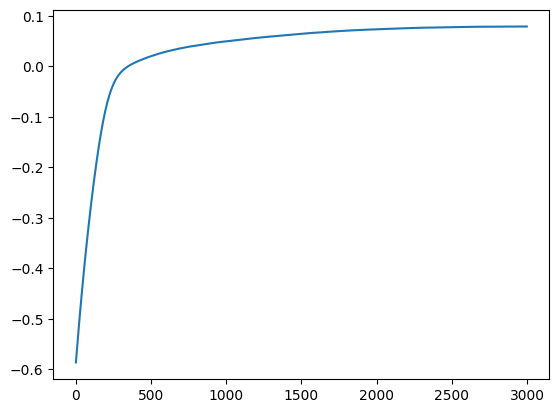

In [177]:
setting = 5 # 1 ~ 8

N = 1000
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

Xtrain = torch.tensor(Xtrain).double()
Xvalid = torch.tensor(Xvalid).double()
Ytrain = torch.tensor(Ytrain).double()

mlp = MLP_l1(hidden_layer_sizes=(32, ) * 2, alpha=3e-2, lr=1e-4).double()

r2 = []

for epoch in range(3000):
    mlp.partial_fit(Xtrain, (Ytrain > 0).double())
    
    Ypred = mlp.predict(Xvalid).detach().numpy()
    r2.append(r2_score(Yvalid > 0, Ypred))

plt.plot(r2)
plt.show()

In [ ]:
N = 1000
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

Xtrain = torch.tensor(Xtrain).double()
Xvalid = torch.tensor(Xvalid).double()
Ytrain = torch.tensor(Ytrain).double()

mlp = MLP_l1(hidden_layer_sizes=(32, ) * 2, alpha=3e-2, lr=1e-4).double()

r2 = []

for epoch in range(3000):
    mlp.partial_fit(Xtrain, (Ytrain > 0).double())
    
    Ypred = mlp.predict(Xvalid).detach().numpy()
    r2.append(r2_score(Yvalid > 0, Ypred))

plt.plot(r2)
plt.show()

In [149]:
setting = 5 # 1 ~ 8

N = 1000
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=20)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=20)

mlp = MLPRegressor(hidden_layer_sizes=(32, ) * 4, random_state=0, alpha=3e-2, learning_rate_init=1e-4)

r2 = []

for epoch in range(3000):
    mlp.partial_fit(Xtrain, Ytrain > 0)
    
    Ypred = mlp.predict(Xvalid)
    r2.append(r2_score(Yvalid > 0, Ypred))

c:\Users\Tian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


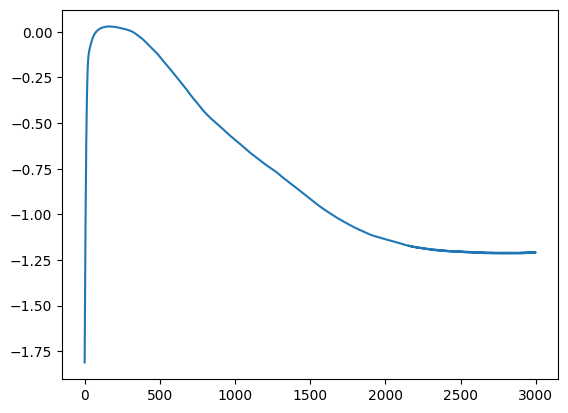

In [152]:
plt.plot(r2)
plt.show()

#### Testing setting 9 - CQR

In [1]:
from utils import gen_data, BH, Bonferroni
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

N = 1000
setting = 9
Xtrain, Ytrain, mu_train = gen_data(setting, N, 0.5, dim=1)
Xvalid, Yvalid, mu_valid = gen_data(setting, N, 0.5, dim=1)

# scaling
# s = StandardScaler()
# Xtrain = s.fit_transform(Xtrain)
# s = StandardScaler()
# Xvalid = s.fit_transform(Xvalid)

# MAV = np.mean(np.absolute(Ytrain), axis=0)
# Ytrain /= MAV  
# MAV = np.mean(np.absolute(Yvalid), axis=0)
# Yvalid /= MAV  

rf = RandomForestRegressor(n_estimators=1000, max_features=1, min_samples_leaf=30)
rf.fit(Xtrain, Ytrain)
Ypred = rf.predict(Xvalid)
print(r2_score(Yvalid, Ypred))

0.4050670968864126


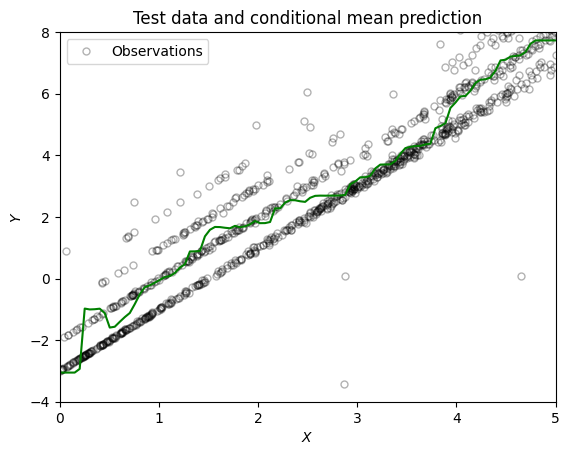

In [2]:
fig = plt.figure()
plt.plot(Xvalid, Yvalid, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')

Yplot_pred = []
for i in np.linspace(0, 5, 100):
    Yplot_pred.append(rf.predict([[i]]))
plt.plot(np.linspace(0, 5, 100), Yplot_pred, color='green')

plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data and conditional mean prediction')
plt.ylim((-4, 8))
plt.xlim((0, 5))
plt.show()

In [ ]:
from utils import BH
Xcalib, Ycalib, mu_calib = gen_data(setting, N, 0.5, dim=1)
Xtest, Ytest, _ = gen_data(setting, N, 0.5, dim=1)

calib_scores0 = - rf.predict(Xcalib)  
calib_scores_2clip = 1000 * (Ycalib > 0) - rf.predict(Xcalib) 

Ypred = rf.predict(Xtest) 
test_scores = -Ypred

BH_sub_sel, BH_sub_p = BH(calib_scores0, test_scores, 0.1)
BH_clip_sel, BH_clip, p = BH(calib_scores_2clip, test_scores, 0.1)



In [3]:
from quantile_forest import RandomForestQuantileRegressor

rf_q = RandomForestQuantileRegressor(n_estimators=1000, min_samples_leaf=40, max_features=1)
rf_q.fit(Xtrain, Ytrain)

RandomForestQuantileRegressor(max_features=1, min_samples_leaf=40,
                              n_estimators=1000)

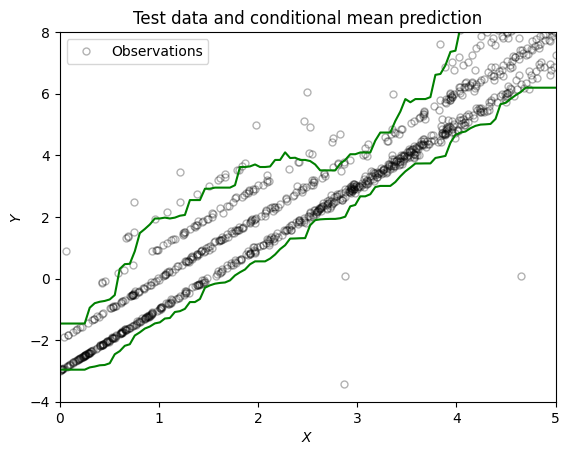

In [4]:
fig = plt.figure()
plt.plot(Xvalid, Yvalid, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')

Yplot_pred_lo = []
Yplot_pred_hi = []
for i in np.linspace(0, 5, 100):
    Yplot_pred_lo.append(rf_q.predict([[i]], quantiles=0.05))
    Yplot_pred_hi.append(rf_q.predict([[i]], quantiles=0.95))
plt.plot(np.linspace(0, 5, 100), Yplot_pred_lo, color='green')
plt.plot(np.linspace(0, 5, 100), Yplot_pred_hi, color='green')

plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data and conditional mean prediction')
plt.ylim((-4, 8))
plt.xlim((0, 5))
plt.show()